In [84]:
import numpy as np
import matplotlib.pyplot as plt

In [353]:
class Splitter:
    def __init__(self, criterion):
        self.criterion = getattr(self, criterion) 
        
    def gini(self, y, splits, y_pred=None):
        cumulative = np.cumsum(y, 0)
        initial = np.sum((cumulative[-1] / y.shape[0]) ** 2)
        left_ns = splits.reshape(-1,1) + 1.0
        right_ns = y.shape[0] - left_ns

        left_ps = cumulative[splits] / left_ns
        right_ps = (cumulative[-1] - cumulative[splits]) / right_ns

        left_ws = left_ns / y.shape[0]
        right_ws = 1 - left_ws

        left_gs = np.sum(left_ps ** 2, 1)
        right_gs = np.sum(right_ps ** 2, 1)

        gs = initial-(left_ws.ravel() * left_gs + right_ws.ravel() * right_gs)
        return gs
    
    def mse(self, y, splits, y_pred=None):
        left_plain = np.cumsum(y)
        left_squared = np.cumsum(y ** 2)

        initial = (left_squared[-1] - left_plain[-1] ** 2 / y.shape[0]) / y.shape[0]

        right_plain = left_plain[-1] - left_plain
        right_squared = left_squared[-1] - left_squared

        left_ns = splits + 1.0
        right_ns = y.shape[0] - left_ns

        left_ws = left_ns / y.shape[0]
        right_ws = 1 - left_ws

        left_vs = (left_squared[splits] - left_plain[splits] ** 2 / left_ns) / left_ns
        right_vs = (right_squared[splits] - right_plain[splits] ** 2 / right_ns) / right_ns

        vs = (left_ws * left_vs + right_ws * right_vs) - initial
        return vs
    
    def xgboost(self, y, splits, y_pred, alpha=0.1, gamma=0.1):
        g = -y * np.exp(-y * y_pred)
        s = y**2 * np.exp(-y * y_pred)

        g_left = np.cumsum(g, 0)
        g_right = g_left[-1] - g_left
        
        s_left = np.cumsum(s, 0)
        s_right = s_left[-1] - s_left
        
        g_left_splits = g_left[splits]
        g_right_splits = g_right[splits]
        s_left_splits = s_left[splits]
        s_right_splits = s_right[splits]
        
        ret = gamma - (g_left_splits ** 2) / (s_left_splits + alpha) - \
              (g_right_splits ** 2) / (s_right_splits + alpha) + \
              (g_left_splits + g_right_splits) ** 2 / (s_left_splits + s_right_splits + alpha)
        return None if np.count_nonzero(ret > 0) == y.shape[0] else ret
        # return ret
    
    def _sort_samples(self, x, y, y_pred):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx], sorted_idx, None if y_pred is None else y_pred[sorted_idx]

    def get_best_split_for_feature(self, X, y, feature, y_pred=None, **kwargs):
        x = X[:, feature]
        x, y, sorted_idx, y_pred = self._sort_samples(x, y, y_pred)
        
        possible_splits = np.where(x[1:] != x[:-1])[0]
        if len(possible_splits) == 0:
            return
        
        gain = self.criterion(y, possible_splits, y_pred, **kwargs)
        if gain is None:
            return
        best_split = np.argmin(gain)
        value_split = (x[possible_splits[best_split]] + x[possible_splits[best_split] + 1]) / 2.0
        left_idx = sorted_idx[:possible_splits[best_split] + 1]
        right_idx = sorted_idx[possible_splits[best_split] + 1:]
        return value_split, gain[best_split], left_idx, right_idx, feature

    def fit(self, X, y, y_pred=None, **kwargs):
        best_loss = 0
        left_idx, right_idx, self.feature, self.theta = None, None, None, None
        
        gains = [self.get_best_split_for_feature(X, y, feature, y_pred, **kwargs) for feature in range(X.shape[1])]
        
        temp = min([x for x in gains if x], key=lambda x: x[1])
        if temp:
            self.theta, best_loss, left_idx, right_idx, self.feature = temp

        return left_idx, right_idx
    
    def predict(self, X):
        return X[:, self.feature] > self.theta

In [354]:
class Node:
    def __init__(self, criterion, node_id):
        self.node_id = node_id
        self.splitter = Splitter(criterion)
        self.is_leaf = False

    def make_leaf(self, X, y):
        self.is_leaf = True
        self.mean = np.mean(y)

    def split(self, X, y, y_pred=None, **kwargs):
        return self.splitter.fit(X, y, y_pred, **kwargs)

    def predict(self, X):
        if self.is_leaf:
            return np.full([X.shape[0]], self.mean)
        else:
            return self.splitter.predict(X)

In [355]:
class CART: 
    def __init__(self, criterion='gini', max_depth=None, min_samples_split=2, max_features='n_features', **kwargs):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self._y_pred = None
        self.kwargs = kwargs
        
    def _get_feature_ids_sqrt(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.sqrt(n_feature))]
        
    def _get_feature_ids_log2(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.log2(n_feature))]

    def _get_feature_ids_N(self, n_feature):
        return range(n_feature)
        
    def _make_node(self):
        n = Node(self.criterion, len(self.nodes))
        self.nodes.append(n)
        return n
    
    def _fit_node(self, X, y, depth, y_pred=None):
        node = self._make_node()
        is_leaf = (self.max_depth and depth == self.max_depth) or \
                  (y.shape[0] < self.min_samples_split) or \
                  (np.unique(y).shape[0] == 1)
        if is_leaf:
            node.make_leaf(X, y)
            return node.node_id

        node.features = self._get_features(X.shape[1])
        left_node_idx, right_node_idx = node.split(X[:, node.features], y, y_pred, **self.kwargs)
        if left_node_idx is None or right_node_idx is None:
            node.make_leaf(X, y)
            return node.node_id
        
        node.left = self._fit_node(X[left_node_idx], y[left_node_idx], depth+1, None if y_pred is None else y_pred[left_node_idx])
        node.right = self._fit_node(X[right_node_idx], y[right_node_idx], depth+1, None if y_pred is None else y_pred[right_node_idx])

        return node.node_id
        
    def fit(self, X, y, y_pred=None):
        self.total_features = X.shape[1]
        if self.max_features == 'n_features':
            self._get_features = self._get_feature_ids_N
        if self.max_features == 'sqrt':
            self._get_features = _get_feature_ids_sqrt
        if self.max_features == 'log2':
            self._get_features = _get_feature_ids_log2
        
        self.nodes = []
        self._fit_node(X, y, 0, y_pred)
    
    def _terminal_leaves(self, X, node_id):
        ids = np.array([node_id for _ in range(X.shape[0])], dtype=np.int)
        node = self.nodes[node_id]
        if node.is_leaf:
            return ids

        node_split = node.predict(X[:,node.features])      
        right_size = np.count_nonzero(node_split)
        if right_size != 0:
            ids[node_split] = self._terminal_leaves(X[node_split], node.right)
        if right_size != X.shape[0]:
            ids[node_split == False] = self._terminal_leaves(X[node_split == False], node.left)
        return ids
    
    def predict_proba(self, X):
        if len(X.shape) == 1:
            X = X.reshape(1, -1)
        y = np.empty([X.shape[0]])

        leaves = self._terminal_leaves(X, 0)
        for leaf in np.unique(leaves):
            mask = leaves == leaf
            y[mask] = self.nodes[leaf].predict(X[mask])
        return y
    
    def predict(self, X):
        return (self.predict_proba(X) > 0) * 1

In [356]:
class AdaboostLoss:
    def __init__(self):
        self.b = 1
        
    def value(self, y, y_pred):
        return np.mean(np.exp(-y * y_pred))
        
    def antigradient(self, y, y_pred):
        return y * np.exp(-y * y_pred)
    
    def update_b_with_newton_raphson(self, y, y_pred):
        numerator = np.sum(y * np.exp(-y * y_pred))
        denominator = np.sum(np.exp(-y * y_pred))
        if abs(denominator) < 1e-30:
            return 0
        return numerator / denominator

In [357]:
class GradientBoosting:
    def __init__(self, base_model, n_estimators, learning_rate=0.1, loss=AdaboostLoss, init_model=None, **kwargs):
        self.n_estimators = n_estimators
        self.base_model = base_model
        self.loss = loss()
        self.init_model = (init_model or base_model)(**kwargs)
        self.kwargs = kwargs
        self.losses = []
        self.test_losses = []
        self.learning_rate = learning_rate
        
    def fit(self, X, y):
        self.models = []
        self.init_model.fit(X, y)
        y_pred = self.init_model.predict_proba(X)
        for i in range(self.n_estimators):
            tree = self.base_model(**self.kwargs)
            antigradient = self.loss.antigradient(y, y_pred)
            tree.fit(X, antigradient)

            leaves = tree._terminal_leaves(X, 0)
            for leaf in np.unique(leaves):
                mask = leaves == leaf
                tree.nodes[leaf].mean = self.learning_rate * self.loss.update_b_with_newton_raphson(y[mask], y_pred[mask])

            y_pred += tree.predict_proba(X)
            self.models.append(tree)
            self.losses.append(self.loss.value(y_pred, y))
            
    def predict_proba(self, X):
        pred = self.init_model.predict_proba(X)
        for tree in self.models:
            pred = pred + tree.predict_proba(X)
        return pred
    
    def predict(self, X):
        return np.array([1 if x > 0 else -1 for x in self.predict_proba(X)])

In [342]:
class InitModel:
    def __init__(self, scale=None, **kwargs):
        self.scale = scale or 0.5
        
    def fit(self, X, y):
        pos = np.count_nonzero(y > 0)
        neg = np.count_nonzero(y < 0)
        self.value = self.scale * np.log((pos * 1.) / neg)
        
    def predict_proba(self, X):
        ret = np.empty(X.shape[0], dtype=np.float64)
        ret.fill(self.value)
        return ret

In [91]:
temp = np.loadtxt('spam.train.class.txt')
y = np.array([1 if t else -1 for t in temp[:,0]])
X = temp[:, 1:]

In [92]:
temp = np.loadtxt('spam.test.class.txt')
y_test = np.array([1 if t else -1 for t in temp[:,0]])
X_test = temp[:, 1:]

In [51]:
boosting = GradientBoosting(base_model=CART, init_model=InitModel, n_estimators=300, max_depth=4, min_samples_split=2, learning_rate=0.1, criterion='mse')

In [52]:
boosting.fit(X, y)

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

In [94]:
sklearn_model = GradientBoostingClassifier(loss='exponential', max_depth=4, n_estimators=400, criterion='mse', min_samples_split=2, learning_rate=0.1)

In [95]:
sklearn_model.fit(X, y)

GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.1,
              loss='exponential', max_depth=4, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=400, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

Adaboost loss:

In [53]:
print "sklearn on train = ", sklearn_model.train_score_[-1]
print "custom on train = ", boosting.losses[-1]
print "sklearn on test = ", AdaboostLoss().value(y_test, sklearn_model.decision_function(X_test))
print "custom on test = ", AdaboostLoss().value(y_test, boosting.predict_proba(X_test))

sklearn on train =  0.01960860532458314
custom on train =  0.019424908725423837
sklearn on test =  0.4764908225981973
custom on test =  0.4751301429577865


Adaboost loss on train:

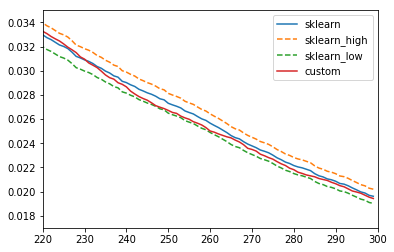

In [38]:
plt.plot(range(300), sklearn_model.train_score_, label='sklearn')
plt.plot(range(300), sklearn_model.train_score_ * 1.03, label='sklearn_high', linestyle = '--')
plt.plot(range(300), sklearn_model.train_score_ * 0.97, label='sklearn_low', linestyle = '--')
plt.plot(range(300), boosting.losses, label='custom')
plt.ylim(0.017, 0.035)
plt.xlim(220, 300)
plt.legend()

Accuracy:

In [26]:
print "custom train accuracy = ", 1. * np.count_nonzero(boosting.predict(X) == y) / X.shape[0]
print "custom test accuracy = ", 1. * np.count_nonzero(boosting.predict(X_test) == y_test) / X_test.shape[0]
print "sklearn train accuracy = ", 1. * np.count_nonzero(sklearn_model.predict(X) == y) / X.shape[0]
print "sklearn test accuracy = ", 1. * np.count_nonzero(sklearn_model.predict(X_test) == y_test) / X_test.shape[0]

custom train accuracy =  1.0
custom test accuracy =  0.956841686555
sklearn train accuracy =  1.0
sklearn test accuracy =  0.957438345267


In [405]:
class XGBOOST:
    def __init__(self, base_model, n_estimators, loss=AdaboostLoss, init_model=None, alpha=0.1, learning_rate=0.1, 
                 gamma=0.1, **kwargs):
        self.n_estimators = n_estimators
        self.base_model = base_model
        self.loss = loss()
        self.init_model = (init_model or base_model)(**kwargs)
        self.kwargs = kwargs
        self.losses = []
        self.alpha = alpha
        self.gamma = gamma
        self.test_losses = []
        self.learning_rate = learning_rate
        
    def fit(self, X, y):
        self.models = []
        self.init_model.fit(X, y)
        y_pred = self.init_model.predict_proba(X)
        for i in range(self.n_estimators):
            tree = self.base_model(criterion='xgboost', alpha=self.alpha, gamma=self.gamma, **self.kwargs)
            tree.fit(X, y, y_pred)

            leaves = tree._terminal_leaves(X, 0)
            for leaf in np.unique(leaves):
                mask = leaves == leaf
                g = np.sum(-y[mask] * np.exp(-y[mask] * y_pred[mask]))
                s = np.sum(y[mask]**2 * np.exp(-y[mask] * y_pred[mask]))
                tree.nodes[leaf].mean = self.learning_rate * (-g / (s + self.alpha))

            y_pred += tree.predict_proba(X)
            self.models.append(tree)
            self.losses.append(self.loss.value(y_pred, y))
            
    def predict_proba(self, X):
        pred = self.init_model.predict_proba(X)
        for tree in self.models:
            pred = pred + tree.predict_proba(X)
        return pred
    
    def predict(self, X):
        return np.array([1 if x > 0 else -1 for x in self.predict_proba(X)])

In [417]:
xgboost = XGBOOST(base_model=CART, init_model=InitModel, n_estimators=300, max_depth=3, min_samples_split=2, alpha=2, gamma=0.1, learning_rate=0.1)

In [418]:
xgboost.fit(X, y)

In [408]:
from xgboost.sklearn import XGBClassifier

In [409]:
def adaboost_loss(y, y_pred):
    t = 2 * y_pred.get_label() - 1
    return np.mean(np.exp(-y * t))

In [410]:
def evalerror(y, y_pred):
    return 'adaboost', adaboost_loss(y, y_pred)

In [411]:
xg = XGBClassifier(objective='binary:logitraw', obj=adaboost_loss, min_child_weight=2, max_depth=3, n_estimators=300, reg_lambda=2, gamma=0.1, learning_rate=0.1)

In [412]:
xg.fit(X, y, eval_set=[(X, y), (X_test, y_test)], eval_metric=evalerror)

[0]	validation_0-auc:0.923277	validation_1-auc:0.898447	validation_0-adaboost:0.887862	validation_1-adaboost:0.91535
[1]	validation_0-auc:0.936298	validation_1-auc:0.908514	validation_0-adaboost:0.801792	validation_1-adaboost:0.859742
[2]	validation_0-auc:0.948522	validation_1-auc:0.92047	validation_0-adaboost:0.734605	validation_1-adaboost:0.796703
[3]	validation_0-auc:0.94716	validation_1-auc:0.925261	validation_0-adaboost:0.681604	validation_1-adaboost:0.756472
[4]	validation_0-auc:0.962046	validation_1-auc:0.938213	validation_0-adaboost:0.630751	validation_1-adaboost:0.729757
[5]	validation_0-auc:0.966848	validation_1-auc:0.941624	validation_0-adaboost:0.59028	validation_1-adaboost:0.67356
[6]	validation_0-auc:0.969932	validation_1-auc:0.946145	validation_0-adaboost:0.552614	validation_1-adaboost:0.66776
[7]	validation_0-auc:0.971647	validation_1-auc:0.948749	validation_0-adaboost:0.523541	validation_1-adaboost:0.651903
[8]	validation_0-auc:0.974026	validation_1-auc:0.949349	valida

[70]	validation_0-auc:0.997474	validation_1-auc:0.982521	validation_0-adaboost:0.13477	validation_1-adaboost:0.289441
[71]	validation_0-auc:0.997499	validation_1-auc:0.982386	validation_0-adaboost:0.134049	validation_1-adaboost:0.29361
[72]	validation_0-auc:0.997569	validation_1-auc:0.982899	validation_0-adaboost:0.132454	validation_1-adaboost:0.28968
[73]	validation_0-auc:0.997594	validation_1-auc:0.983057	validation_0-adaboost:0.131914	validation_1-adaboost:0.288656
[74]	validation_0-auc:0.997646	validation_1-auc:0.982998	validation_0-adaboost:0.13067	validation_1-adaboost:0.291687
[75]	validation_0-auc:0.997672	validation_1-auc:0.983101	validation_0-adaboost:0.129971	validation_1-adaboost:0.293694
[76]	validation_0-auc:0.997705	validation_1-auc:0.983272	validation_0-adaboost:0.129115	validation_1-adaboost:0.295954
[77]	validation_0-auc:0.997744	validation_1-auc:0.983393	validation_0-adaboost:0.128015	validation_1-adaboost:0.292229
[78]	validation_0-auc:0.997802	validation_1-auc:0.98

[139]	validation_0-auc:0.999161	validation_1-auc:0.98445	validation_0-adaboost:0.080458	validation_1-adaboost:0.472709
[140]	validation_0-auc:0.999169	validation_1-auc:0.984258	validation_0-adaboost:0.080008	validation_1-adaboost:0.478035
[141]	validation_0-auc:0.999183	validation_1-auc:0.984268	validation_0-adaboost:0.079414	validation_1-adaboost:0.480395
[142]	validation_0-auc:0.999195	validation_1-auc:0.984325	validation_0-adaboost:0.07887	validation_1-adaboost:0.479601
[143]	validation_0-auc:0.999205	validation_1-auc:0.984245	validation_0-adaboost:0.078458	validation_1-adaboost:0.470212
[144]	validation_0-auc:0.999214	validation_1-auc:0.98419	validation_0-adaboost:0.077954	validation_1-adaboost:0.474532
[145]	validation_0-auc:0.999219	validation_1-auc:0.984327	validation_0-adaboost:0.077773	validation_1-adaboost:0.468251
[146]	validation_0-auc:0.999219	validation_1-auc:0.984443	validation_0-adaboost:0.077545	validation_1-adaboost:0.47061
[147]	validation_0-auc:0.999227	validation_1

[208]	validation_0-auc:0.999656	validation_1-auc:0.985306	validation_0-adaboost:0.054857	validation_1-adaboost:0.514751
[209]	validation_0-auc:0.999662	validation_1-auc:0.985349	validation_0-adaboost:0.054376	validation_1-adaboost:0.526801
[210]	validation_0-auc:0.999667	validation_1-auc:0.985294	validation_0-adaboost:0.054067	validation_1-adaboost:0.52884
[211]	validation_0-auc:0.99967	validation_1-auc:0.985342	validation_0-adaboost:0.053908	validation_1-adaboost:0.527287
[212]	validation_0-auc:0.999676	validation_1-auc:0.985489	validation_0-adaboost:0.053549	validation_1-adaboost:0.512242
[213]	validation_0-auc:0.999684	validation_1-auc:0.985451	validation_0-adaboost:0.053183	validation_1-adaboost:0.514071
[214]	validation_0-auc:0.99969	validation_1-auc:0.985401	validation_0-adaboost:0.052792	validation_1-adaboost:0.520202
[215]	validation_0-auc:0.999693	validation_1-auc:0.985436	validation_0-adaboost:0.052551	validation_1-adaboost:0.518464
[216]	validation_0-auc:0.999702	validation_

[277]	validation_0-auc:0.999902	validation_1-auc:0.986264	validation_0-adaboost:0.036027	validation_1-adaboost:0.648212
[278]	validation_0-auc:0.999903	validation_1-auc:0.986296	validation_0-adaboost:0.035753	validation_1-adaboost:0.65197
[279]	validation_0-auc:0.999905	validation_1-auc:0.986294	validation_0-adaboost:0.035538	validation_1-adaboost:0.651726
[280]	validation_0-auc:0.999906	validation_1-auc:0.986353	validation_0-adaboost:0.035324	validation_1-adaboost:0.64701
[281]	validation_0-auc:0.999908	validation_1-auc:0.986372	validation_0-adaboost:0.035126	validation_1-adaboost:0.646964
[282]	validation_0-auc:0.99991	validation_1-auc:0.986409	validation_0-adaboost:0.035041	validation_1-adaboost:0.645768
[283]	validation_0-auc:0.999911	validation_1-auc:0.986429	validation_0-adaboost:0.034919	validation_1-adaboost:0.647719
[284]	validation_0-auc:0.999911	validation_1-auc:0.986376	validation_0-adaboost:0.034842	validation_1-adaboost:0.645148
[285]	validation_0-auc:0.999912	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=300,
       n_jobs=1, nthread=None,
       obj=<function adaboost_loss at 0x7fe52c09db18>,
       objective='binary:logitraw', random_state=0, reg_alpha=0,
       reg_lambda=2, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [413]:
losses = xg.evals_result()

In [414]:
model_train_losses = np.array(losses["validation_0"]["adaboost"])
model_test_losses = np.array(losses["validation_1"]["adaboost"])

In [419]:
print "xgboost lib on train = ", model_train_losses[-1]
print "custom on train = ", xgboost.losses[-1]
print "xgboost lib on test = ", model_test_losses[-1]
print "custom on test = ", AdaboostLoss().value(y_test, xgboost.predict_proba(X_test))

xgboost lib on train =  0.031676
custom on train =  0.03722863851575831
xgboost lib on test =  0.704272
custom on test =  0.36575077033153774


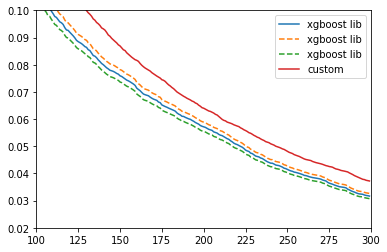

In [420]:
plt.plot(range(300), model_train_losses, label='xgboost lib')
plt.plot(range(300), model_train_losses * 1.03, label='xgboost lib', linestyle = '--')
plt.plot(range(300), model_train_losses * 0.97, label='xgboost lib', linestyle = '--')
plt.plot(range(300), xgboost.losses, label='custom')
plt.ylim(0.02, 0.1)
plt.xlim(100, 300)
plt.legend()